# Genetic Algorithms

This notebook is part of [AI for Beginners Curriculum](http://github.com/microsoft/ai-for-beginners).

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## Some Theory

**Genetic Algorithms** (GA) are based on **evolutionary approach** to AI, in which methods of evolution of population is used to obtain an optimal solution for a given problem. They were proposed in 1975 by [John Henry Holland](https://en.wikipedia.org/wiki/John_Henry_Holland).

Genetic Algorithms are based on the following ideas:
* Valid solutions to the problem can be represented as **genes**
* **Crossover** allows us to combine two solutions together to obtain new valid solution
* **Selection** is used to select more optimal solutions using some **fitness function**
* **Mutations** are introduced to destabilize optimization and get us out of the local minimum 

If you want to implement a Genetic Algorithm, you need the following:

 * To find a method of coding our problem solutions using **genes** $g\in\Gamma$
 * On the set of genes $\Gamma$ we need to define **fitness function** $\mathrm{fit}: \Gamma\to\mathbb{R}$. Smaller function values would correspond to better solutions.
 * To define **crossover** mechanism to combine two genes together to get a new valid solution $\mathrm{crossover}: \Gamma^2\to\Gamma$.
 * To define **mutation** mechanism $\mathrm{mutate}: \Gamma\to\Gamma$.
In many cases, crossover and mutation are quite simple algorithms to manipulate genes as numeric sequences or bit vectors.

Specific implementation of a genetic algorithm can vary from case to case, but overall structure is the following:

1. Select initial population $G\subset\Gamma$
2. Randomly select one of the operations that will be performed at this step: crossover or mutation 
3. **Crossover**:
  * Randomly select two genes $g_1, g_2 \in G$
  * Compute crossover $g=\mathrm{crossover}(g_1,g_2)$
  * If $\mathrm{fit}(g)<\mathrm{fit}(g_1)$ or $\mathrm{fit}(g)<\mathrm{fit}(g_2)$ - replace corresponding gene in the population by $g$.
4. **Mutation** - select random gene $g\in G$ and replace it by $\mathrm{mutate}(g)$
5. Repeat from step 2, until we get sufficiently small value of $\mathrm{fit}$, or until the limit on the number of steps is reached.

Tasks typically solved by GA:
1. Schedule optimization
1. Optimal packing
1. Optimal cutting
1. Speeding up exhaustive search


## Problem 1: Fair Treasure Split

**Task**: 
Two people found a treasure that contains diamonds of different sizes (and, correspondingly, different price). They need to split the treasure in two parts in such a way that the difference in the price is 0 (or minimal).

**Formal definition**: 
We have a set of numbers $S$. We need to split it into two subsets $S_1$ and $S_2$, such that $$\left|\sum_{i\in S_1}i - \sum_{j\in S_2}j\right|\to\min$$ and $S_1\cup S_2=S$, $S_1\cap S_2=\emptyset$.

First of all, let's define the set $S$:

In [3]:
N = 200
S = np.array([random.randint(1,10000) for _ in range(N)])
print(S)

[8344 2197 9335 3131 5863 9429 3818 9791   15 5455 1396 9538 4872 6549
 8587 5986 6021 9764 8102 5083 5739 7684 8498 3007 6599  820 7490 2372
 9370 5235 3525 3154  859 1906 8159 3950 2173 2988 2050  349 8713 2284
 4177 6033 1651 9176 5049 8201  171 5081 1216 3756 4711 2757 7738 1272
 5650 6584 5395 9004 7797  969 8104 1283 1392 4001 5768  445  274  256
 8239 8015 4381 9021 1189 8879 1411 3539 6526 8011  136 7230 2332  451
 5702 2989 4320 2446 9578 8486 4027 2410 9588 8981 2177 1493 3232 9151
 4835 5594 6859 8394  369 3200  126 4259 2283 7755 2014 2458 8327 8082
 7413 7622 1206 5533 8751 3495 5868 8472 6850 3958 3149 4672 4810 6274
 4700 6134 4627 4616 6656 9949  884 2256 7419 1926 7973 5319 5967 9158
 3823 7697 9466 5675 5412 9784 5426 8209 3421 1136 6047 4429 8001 4417
 1381  722 7350 6018 6235 7860 5853 7660 5937 6242    1 9552 3971 8302
 2633 9227 7283  154 8599 4269 9392 8539 1630  368 2409 9351 3838 9814
 6186 5743 5083 1325 1610  779 3643 3262 5768 8725  961 4611 6310 4788
 1648 

Let's encode each possible solution of the problem by a binary vector $B\in\{0,1\}^N$, where the number on $i$-th position shows to which of the sets ($S_1$ or $S_2$) the $i$-th number in the original set $S$ belongs. `generate` function will generate those random binary vectors.

In [5]:
def generate(S):
    return np.array([random.randint(0,1) for _ in S])

b = generate(S)
print(b)

[1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1
 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0]


Let's now define `fit` function that calculates the "cost" of the solution. It will be the difference between sum or two sets, $S_1$ and $S_2$:

In [6]:
def fit(B,S=S):
    c1 = (B*S).sum()
    c2 = ((1-B)*S).sum()
    return abs(c1-c2)

fit(b)

133784

Now we need to define functions for mutation and crossover:
* For mutation, we will select one random bit and negate it (change from 0 to 1 and vice versa)
* For crossover, we will take some bits from one vector, and some bits from another one. We will use the same `generate` function to randomly select, which bits to take from which of the input masks.

In [7]:
def mutate(b):
    x = b.copy()
    i = random.randint(0,len(b)-1)
    x[i] = 1-x[i]
    return x

def xover(b1,b2):
    x = generate(b1)
    return b1*x+b2*(1-x)

Let's create initial population of the solutions $P$ of the size `pop_size`:

In [8]:
pop_size = 30
P = [generate(S) for _ in range(pop_size)]

Now, the main function to perform the evolution. `n` is the number of steps of evolution to undergo. At each step:
* With the probability of 30% we perform a mutation, and replace the element with the worst `fit` function by the mutated element
* With the probability of 70% we perform crossover

The function returns the best solution (gene corresponding to the best solution), and the history of minimal fit function in the population on each iteration.

In [9]:
def evolve(P,S=S,n=2000):
    res = []
    for _ in range(n):
        f = min([fit(b) for b in P])
        res.append(f)
        if f==0:
            break
        if random.randint(1,10)<3:
            i = random.randint(0,len(P)-1)
            b = mutate(P[i])
            i = np.argmax([fit(z) for z in P])
            P[i] = b
        else:
            i = random.randint(0,len(P)-1)
            j = random.randint(0,len(P)-1)
            b = xover(P[i],P[j])
            if fit(b)<fit(P[i]):
                P[i]=b
            elif fit(b)<fit(P[j]):
                P[j]=b
            else:
                pass
    i = np.argmin([fit(b) for b in P])
    return (P[i],res)

(s,hist) = evolve(P)
print(s,fit(s))

[0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0
 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0
 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1
 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1] 4


You can see that we have managed to minimize the `fit` function quite a bit! Here is the graph that shows how the `fit` function for the whole population behaves during the process.

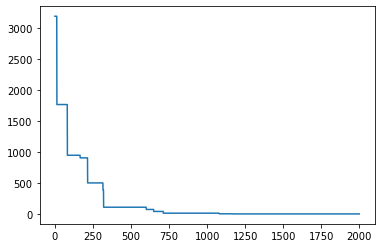

In [10]:
plt.plot(hist)
plt.show()

## Problem 2: N Queens Problem

**Task**:
You need to place $N$ queens on a chess board of the size $N\times N$ in such a way that they do not attack each other.

First of all, let's solve the problem without genetic algorithms, using full search. We can represent the state of the board by the list $L$, where $i$-th number in the list is the horizontal position of the queen in $i$-th row. It is quite obvious that each solution will have only one queen per row, and each row would have a queen.

Our goal would be to find the first solution to the problem, after which we will stop searching. You can easily extend this function to generate all possible positions for queens.

In [11]:
N = 8

def checkbeats(i_new,j_new,l):
    for i,j in enumerate(l,start=1):
        if j==j_new:
            return False
        else:
            if abs(j-j_new) == i_new-i:
                return False
    return True

def nqueens(l,N=8,disp=True):
    if len(l)==N:
        if disp: print(l)
        return True
    else:
        for j in range(1,N+1):
            if checkbeats(len(l)+1,j,l):
                l.append(j)
                if nqueens(l,N,disp): return True
                else: l.pop()
        return False
            
nqueens([],8)


[1, 5, 8, 6, 3, 7, 2, 4]


True

Now let's measure how long does it take to get a solution for 20-queens problem:

In [12]:
%timeit nqueens([],20,False)

10.6 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now let's solve the same problem using genetic algorithm. This solution is inspired by [this blog post](https://kushalvyas.github.io/gen_8Q.html).

We will represent each solution by the same list of length $N$, and as a `fit` function we will take the number of queens that attack each other:

In [13]:
def fit(L):
    x=0
    for i1,j1 in enumerate(L,1):
        for i2,j2 in enumerate(L,1):
            if i2>i1:
                if j2==j1 or (abs(j2-j1)==i2-i1): x+=1
    return x

Since calculating fitness function is time consuming, let's store each solution in the population together with the value of fitness function. Let's generate the initial population:

In [14]:
def generate_one(N):
    x = np.arange(1,N+1)
    np.random.shuffle(x)
    return (x,fit(x))

def generate(N,NP):
    return [generate_one(N) for _ in range(NP)]

generate(8,5)

[(array([2, 3, 8, 7, 5, 4, 1, 6]), 4),
 (array([3, 4, 5, 1, 2, 8, 6, 7]), 8),
 (array([1, 3, 7, 4, 5, 8, 6, 2]), 6),
 (array([1, 5, 4, 6, 8, 3, 7, 2]), 4),
 (array([3, 5, 7, 1, 8, 6, 4, 2]), 3)]

Now we need to define mutation and crossover functions. Crossover would combine two genes together by breaking them at some random point and concatenating two parts from different genes together.

In [15]:
def mutate(G):
    x=random.randint(0,len(G)-1)
    G[x]=random.randint(1,len(G))
    return G
    
def xover(G1,G2):
    x=random.randint(0,len(G1))
    return np.concatenate((G1[:x],G2[x:]))

xover([1,2,3,4],[5,6,7,8])

array([1, 2, 7, 8])

We will enhance gene selection process by selecting more genes with better fitness function. The probability of selection of a gene would depend on the fitness function: 

In [17]:
def choose_rand(P):
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p = np.random.choice(len(P),2,False,p=w)
    return p[0],p[1]

def choose(P):
    def ch(w):
        p=[]
        while p==[]:
            r = random.random()
            p = [i for i,x in enumerate(P) if x[1]>=r]
        return random.choice(p)
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p1=p2=0
    while p1==p2:
        p1 = ch(w)
        p2 = ch(w)
    return p1,p2

Now let's define the main evolutionary loop. We will make the logic slightly different from previous example, to show that one can get creative. We will loop until we get the perfect solution (fitness function=0), and at each step we will take the current generation, and produce the new generation of the same size. This is done using `nxgeneration` function, using the following steps:

1. Discard the most unfit solutions - there is `discard_unfit` function that does that
1. Add some more random solutions to the generation
1. Populate new generation of size `gen_size` using the following steps for each new gene:
    - select two random genes, with probability proportional to fitness function
    - calculate a crossover
    - apply a mutation with the probability `mutation_prob`

In [20]:
mutation_prob = 0.1

def discard_unfit(P):
    P.sort(key=lambda x:x[1])
    return P[:len(P)//3]

def nxgeneration(P):
    gen_size=len(P)
    P = discard_unfit(P)
    P.extend(generate(len(P[0][0]),3))
    new_gen = []
    for _ in range(gen_size):
        p1,p2 = choose_rand(P)
        n = xover(P[p1][0],P[p2][0])
        if random.random()<mutation_prob:
            n=mutate(n)
        nf = fit(n)
        new_gen.append((n,nf))
        '''
        if (nf<=P[p1][1]) or (nf<=P[p2][1]):
            new_gen.append((n,nf))
        elif (P[p1][1]<P[p2][1]):
            new_gen.append(P[p1])
        else:
            new_gen.append(P[p2])
        '''
    return new_gen
    
def genetic(N,pop_size=100):
    P = generate(N,pop_size)
    mf = min([x[1] for x in P])
    n=0
    while mf>0:
        #print("Generation {0}, fit={1}".format(n,mf))
        n+=1
        mf = min([x[1] for x in P])
        P = nxgeneration(P)
    mi = np.argmin([x[1] for x in P])
    return P[mi]

genetic(8)

(array([4, 7, 5, 3, 1, 6, 8, 2]), 0)

It is interesting that in most of the times we are able to get a solution pretty quickly, but in some rare cases optimization reaches local minimum, and the process is stuck for a long time. It is important to take that into account when you are measuring average time: while in most of the cases genetic algorithm will be faster than full search, in some cases it can take longer. To overcome this problem, it often makes sense to limit the number of generations to consider, and if we are not able to find the solution - we can start from scratch.  

In [19]:
%timeit genetic(10)

The slowest run took 18.71 times longer than the fastest. This could mean that an intermediate result is being cached.
26.4 s ± 28.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
